Tabular Playground Series Feb. 2022 is a competition on genetic data. 10 bacteria will be classified according to the results of genomic analysis in this competition. In this technique, 10-mer snippets of DNA are sampled and analyzed to give the histogram of base count.

In [4]:
import pandas as pd
import numpy as np

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')


display(train.head())
display(sub.head())

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


,row_id,target
0,200000,Streptococcus_pneumoniae
1,200001,Streptococcus_pneumoniae
2,200002,Streptococcus_pneumoniae
3,200003,Streptococcus_pneumoniae
4,200004,Streptococcus_pneumoniae


In [7]:
display(train.shape)
display(test.shape)

(200000, 288)

(100000, 287)

In [8]:
train.drop('row_id', axis=1, inplace=True)
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
object_cols = list(set(train.columns) - set(numeric_cols))
print('numeric cols len: ', len(numeric_cols))
print('object col: ', object_cols)


numeric cols len:  286
object col:  ['target']


In [9]:
for col in numeric_cols:
    if len(train[col].unique()) < 10:
        print(train[col].unique())

#### Check null values

In [26]:
train.isna().sum().sum()

0

#### Check duplicates

In [15]:
duplicates_train = train.duplicated().sum()
duplicates_train

76007

In [17]:
train.drop_duplicates(keep='first', inplace=True)
train.shape

(123993, 287)

#### Memory Usage

In [22]:
mem = train.memory_usage().sum() / 1024**2
print(f'Memory usage of train dataframe is {mem:.2f} MB')

Memory usage of dataframe is 272.45 MB


In [24]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [25]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 137.17 Mb (49.7% reduction)
Mem. usage decreased to 109.48 Mb (50.0% reduction)


#### Distribution

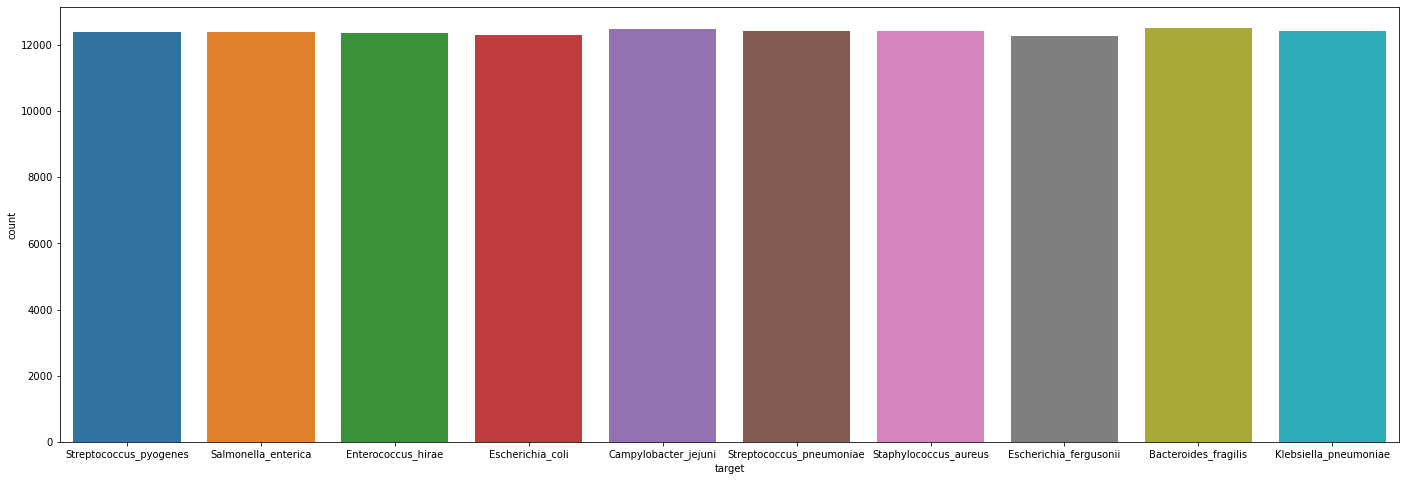

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

fig, ax = plt.subplots(figsize=(24, 8))
sns.countplot(train['target'], ax=ax);